#**Diamond Carats Regression**

Ilaria Tangorre 5307483 - Greta Riva 5306762

**GoogleNet implementation - Diamond Carats Regression**

https://www.kaggle.com/datasets/aayushpurswani/diamond-images-dataset



In [ ]:
!pip install d2l

In [ ]:
from d2l import torch as d2l
import torch
from torch import nn
from torch.nn import functional as F
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##**1. Loading data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
resources = "drive/MyDrive/Colab Notebooks/RISORSE"

Mounted at /content/drive


In [ ]:
path = kagglehub.dataset_download("aayushpurswani/diamond-images-dataset")
print("Path to dataset files:", path)

100%|██████████| 3.08G/3.08G [00:51<00:00, 64.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aayushpurswani/diamond-images-dataset/versions/1


##**2. Data exploration**

In [ ]:
print(os.listdir(path))

['web_scraped']


In [ ]:
main_folder = os.path.join(path, 'web_scraped')
print(os.listdir(main_folder))

['cushion', 'heart', 'princess', 'round', 'oval', 'marquise', 'pear', 'emerald', 'diamond_data.csv']


In [ ]:
csv_path = os.path.join(path, 'web_scraped', 'diamond_data.csv')
df = pd.read_csv(csv_path)
print(df.head())

                       path_to_img stock_number    shape  carat clarity  \
0  web_scraped/cushion/2106452.jpg      2106452  cushion   0.55     SI2   
1  web_scraped/cushion/2042329.jpg      2042329  cushion   0.52     SI2   
2  web_scraped/cushion/2055268.jpg      2055268  cushion   0.50     SI1   
3  web_scraped/cushion/2128779.jpg      2128779  cushion   0.50     VS2   
4  web_scraped/cushion/2103991.jpg      2103991  cushion   0.51     SI1   

  colour cut polish symmetry fluorescence  lab  length  width  depth  
0      N  VG     EX       VG            N  GIA    4.56   4.44   3.09  
1    Y-Z  EX     EX       VG            F  GIA    4.40   4.31   2.99  
2      L  VG     EX       VG            N  GIA    4.87   4.19   2.89  
3      M  EX     EX       VG            F  GIA    4.73   4.28   2.84  
4      M  EX     EX       VG            N  GIA    4.47   4.44   3.05  


In [ ]:
print(df['carat'].describe())

count    48765.000000
mean         0.946133
std          0.564335
min          0.500000
25%          0.550000
50%          0.760000
75%          1.010000
max          8.000000
Name: carat, dtype: float64


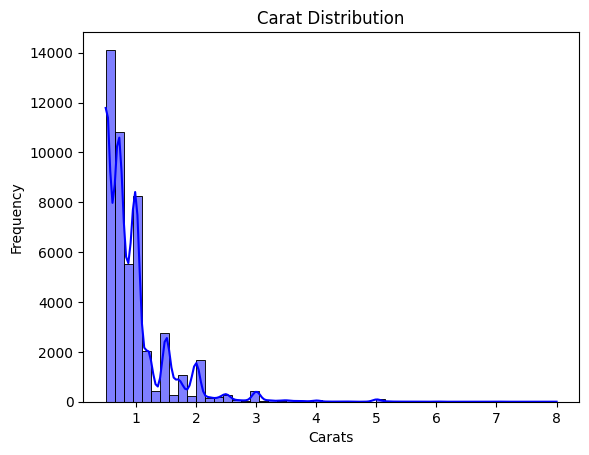

In [ ]:
import numpy as np
sns.histplot(df['carat'], bins=50, kde=True, color='blue')
plt.title("Carat Distribution")
plt.xlabel("Carats")
plt.ylabel("Frequency")
plt.show()

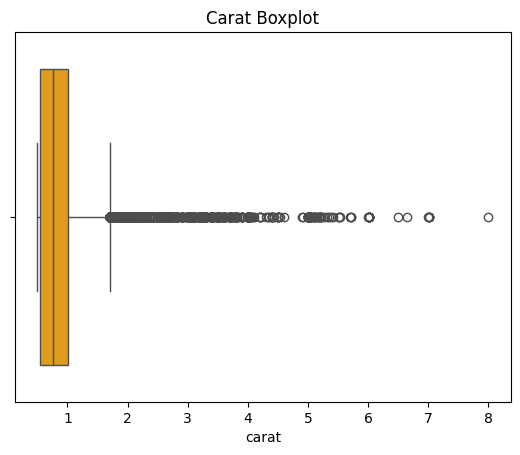

In [ ]:
sns.boxplot(x=df['carat'], color='orange')
plt.title("Carat Boxplot")
plt.show()

##**3. Data cleaning and data visualization**
In our dataset of 48,765 diamond images, most of the diamonds have a carat value below 2.2. Since diamonds with carats greater than 2.2 are rare and underrepresented, we applied a filter to retain only those with carats ≤ 2.2. This allows us to improve the reliability of our regression model by reducing the noise caused by the scarcity of data for diamonds with higher carat values.

In [ ]:
len_pre_filtering = df.shape[0]
df = df[df['carat'] <= 2.2]
len_after_filtering = df.shape[0]
f"We filtered out {len_pre_filtering - len_after_filtering} rows"

'We filtered out 1520 rows'

We remove rows with invalid stock numbers and validate each file to ensure it is in JPEG format. Files that are not JPEGs or are broken are excluded, leaving only valid image files for further analysis.

In [ ]:
import imghdr
from pathlib import Path

def validate_jpeg_file(x):
    fullpath = Path('/kaggle/input/diamond-images-dataset') / x
    img_type = imghdr.what(fullpath)
    ret = (img_type in ['jpeg'])
    if not ret:
        print(f'{fullpath} is not a jpeg. It is {img_type}')
    return ret

def drop_broken_rows(df):
    valid = df['path_to_img'].map(validate_jpeg_file)
    return df.loc[valid]

In [ ]:
df = df.loc[-df['stock_number'].isin(['220376-42', '220188-630'])]
len(df)

47243

In [ ]:
import random
from PIL import Image
def display_random_diamonds_in_grid(df, n=16, base_path='/root/.cache/kagglehub/datasets/aayushpurswani/diamond-images-dataset/versions/1'):
    random_rows = df.sample(n)
    rows, cols = 4, 4

    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.flatten()
    for i, (ax, (_, row)) in enumerate(zip(axes, random_rows.iterrows())):
        path = Path(base_path) / row['path_to_img']
        image = Image.open(path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Carat: {row['carat']}")

    plt.tight_layout()
    plt.show()


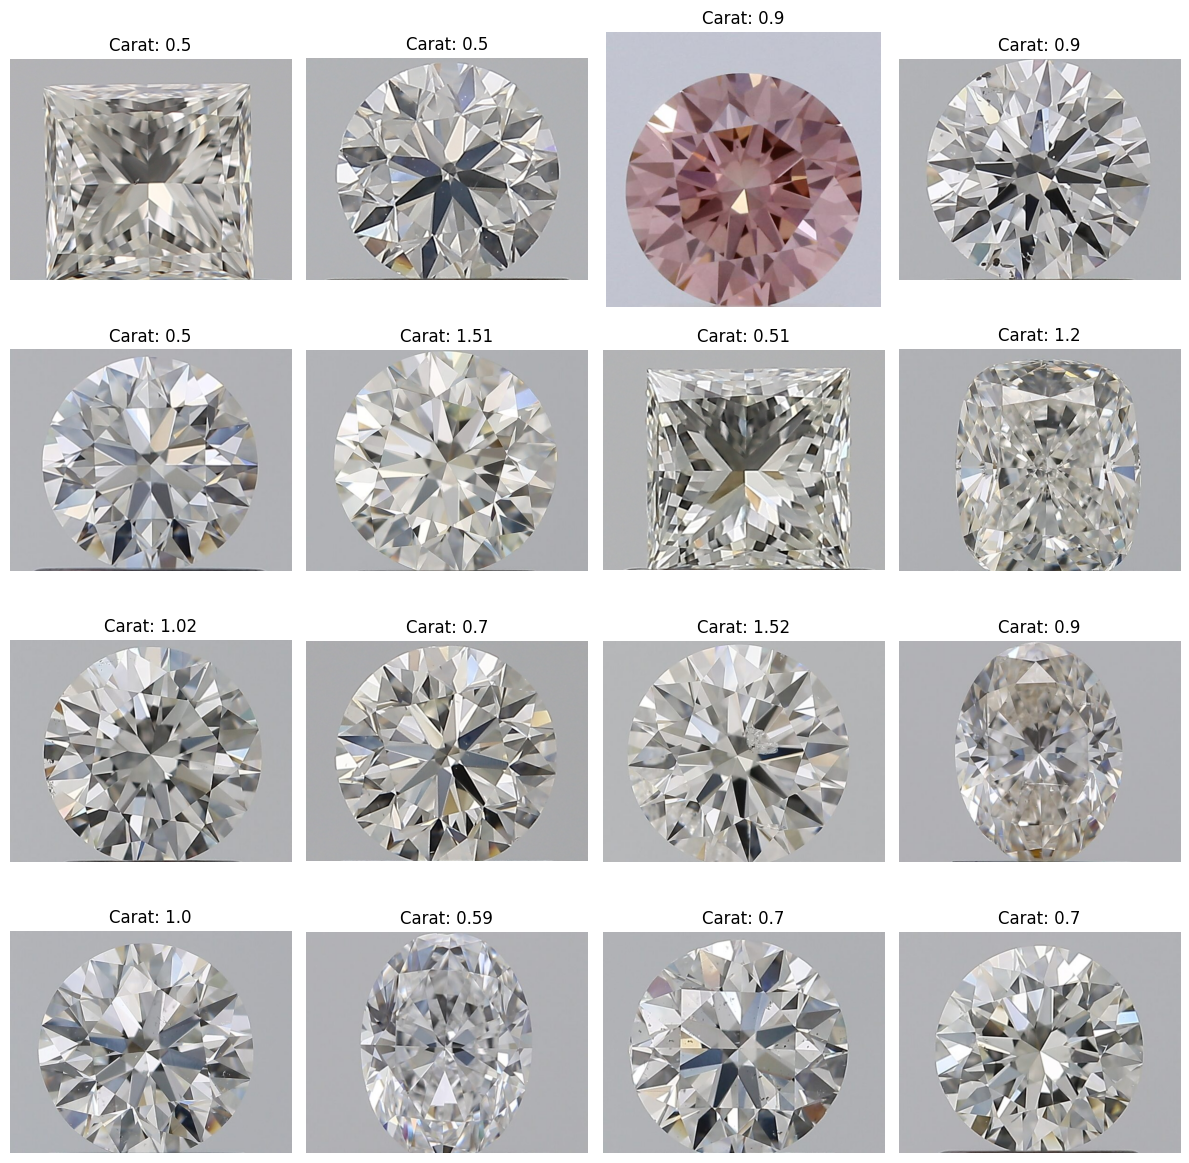

In [ ]:
display_random_diamonds_in_grid(df, n=16, base_path=path)

##**4. Data Preprocessing**
###**4.1 Data augmentation and image normalization**
To preprocess our dataset, we applied several key steps to ensure proper formatting for model input. First, we resized all images to 224x224 pixels, which is a common input size for GoogleNet architecture, ensuring uniformity and efficient handling by the network.

Next, we normalized the pixel intensities by calculating the mean and standard deviation of a sample of 500 images across the RGB channels. These values were used to standardize the pixel values, which improves the convergence speed and stability of the model during training.




In [ ]:
from torchvision import transforms

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

base_path = path

data_augmentation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

sample_size = 500
image_tensors = []

sampled_images = random.sample(range(len(df)), min(len(df), sample_size))

for idx in sampled_images:
    row = df.iloc[idx]
    img_path = Path(base_path) / row['path_to_img']

    try:
        img = Image.open(img_path).convert("RGB")
        tensor = data_augmentation(img)
        image_tensors.append(tensor)
    except Exception as e:
        print(f"Error with the image {img_path}: {e}")

stacked_images = torch.stack(image_tensors)
mean = stacked_images.mean(dim=[0, 2, 3])
std = stacked_images.std(dim=[0, 2, 3])

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image

mean = [0.6709, 0.6699, 0.6707]
std = [0.1388, 0.1389, 0.1423]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

class DiamondDataset(Dataset):
    def __init__(self, dataframe, base_path, transform=None):
        self.dataframe = dataframe
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = Path(self.base_path) / row['path_to_img']
        image = Image.open(img_path).convert("RGB")
        #image = read_image(img_path).float() / 255.0
        label = torch.tensor(row['carat_scaled'], dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

###**4.2 Dataset splitting, scaling and model preparation**

We split the dataset into three parts: training (70%), test (15%), and validation (15%). Additionally, we scaled the carat values, which are the target labels for the regression task, using a MinMaxScaler. This transformation maps the carat values to a range between 0 and 1, ensuring compatibility with the regression model and its output layer, which helps optimize performance in predicting the continuous target. We apply fit_transform only to the training dataset to calculate the scaling parameters (minimum and maximum) based solely on these data, preventing information from the validation or test sets from influencing the training. For the validation and test sets, we use transform to apply the same scaling, ensuring that all data is processed consistently.


In [ ]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(df, test_size=0.3, random_state=42)
test_dataset, val_dataset = train_test_split(test_dataset, test_size=0.5, random_state=42)

In [ ]:
#Scale carat values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() #Using MinMaxScaler to scale the carat values between 0 and 1
train_dataset['carat_scaled'] = scaler.fit_transform(train_dataset[['carat']]) #Fitting scaler only on train dataset
val_dataset['carat_scaled'] = scaler.transform(val_dataset[['carat']])
test_dataset['carat_scaled'] = scaler.transform(test_dataset[['carat']])
train_dataset['carat_scaled'].describe(), val_dataset['carat_scaled'].describe(), test_dataset['carat_scaled'].describe()

(count    33070.000000
 mean         0.221312
 std          0.228240
 min          0.000000
 25%          0.017647
 50%          0.147059
 75%          0.294118
 max          1.000000
 Name: carat_scaled, dtype: float64,
 count    7087.000000
 mean        0.220406
 std         0.230411
 min         0.000000
 25%         0.017647
 50%         0.141176
 75%         0.294118
 max         1.000000
 Name: carat_scaled, dtype: float64,
 count    7086.000000
 mean        0.223277
 std         0.227921
 min         0.000000
 25%         0.035294
 50%         0.147059
 75%         0.294118
 max         1.000000
 Name: carat_scaled, dtype: float64)

In [ ]:
#save the scaler
import pickle

with open(resources+"/scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
train_dataset = DiamondDataset(train_dataset, base_path, transform=transform)
val_dataset = DiamondDataset(val_dataset, base_path, transform=transform)
test_dataset = DiamondDataset(test_dataset, base_path, transform=transform)

In [ ]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for images, labels in train_loader:
    print(f"Batch shape: {images.size()}")
    print(f"Labels: {labels}")
    break

Batch shape: torch.Size([64, 3, 224, 224])
Labels: tensor([0.1176, 0.2941, 0.4118, 0.1176, 0.1412, 0.0000, 0.2353, 0.3059, 0.8824,
        0.1294, 0.0059, 0.1235, 0.3059, 0.0000, 0.0000, 0.2941, 0.5941, 0.1176,
        0.5882, 0.4647, 0.1176, 0.4118, 0.2941, 0.5882, 0.2941, 0.0588, 0.1706,
        0.0000, 0.8824, 0.1176, 0.1471, 0.1941, 0.1471, 0.4118, 0.7588, 0.3000,
        0.1176, 0.0882, 0.0000, 0.1294, 0.1353, 0.0000, 0.0412, 0.0000, 0.0000,
        0.2941, 0.1176, 0.2353, 0.1765, 0.0000, 0.1176, 0.1176, 0.0059, 0.5882,
        0.1176, 0.8824, 0.0000, 0.5882, 0.1765, 0.0059, 0.1294, 0.1294, 0.1176,
        0.0000])


##**5. Convolutional Neural Network**
###**GoogLeNet**
GoogLeNet, introduced in 2014 with the Inception architecture, is a convolutional neural network (CNN) designed to improve computational efficiency while maintaining an high capacity for feature extraction from images. Its main innovation is the use of Inception blocks, which apply convolutions of different sizes (1x1, 3x3, 5x5) and pooling operations (max and average pooling) in parallel. The 1x1 convolutions are used to reduce dimensionality, cutting down on computational costs. This approach allows the network to capture features at different resolutions, enhancing efficiency without exponentially increasing the number of parameters.

For our project, the Inception architecture is composed of a series of these blocks, with each block designed to efficiently gather spatial information from the input images.

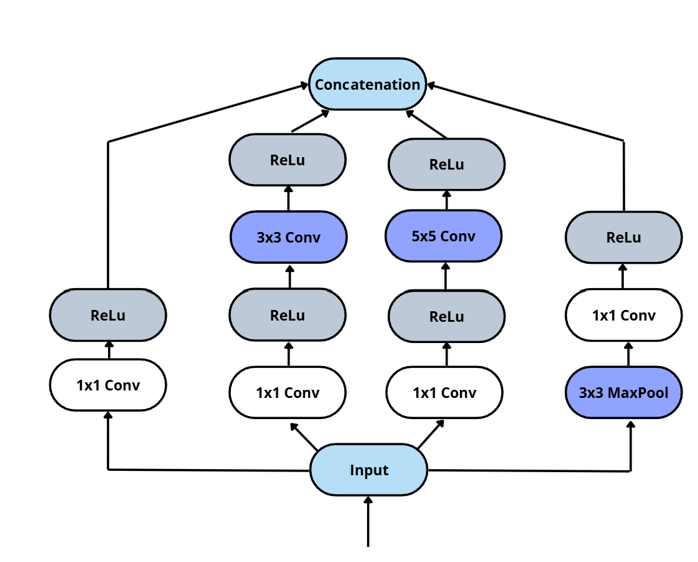

An important innovation in our CNN is the introduction of a Dropout layer (with p=0.4), placed before the final regression phase, between the convolutional layers and the Adaptive Average Pooling layer. This helps reduce overfitting, improving the model's generalization on unseen data.
The Adaptive Average Pooling reduces the spatial dimensions of the image while retaining only the most significant features. The output from this pooling layer is then passed through a fully connected layer, which produces the final prediction: a single value representing, in our case, the diamond carat.

The Inception architecture was chosen due to its ability to balance depth and width. By leveraging various convolution sizes, it captures rich and complex representations of diamond images, while keeping the parameter count manageable, making it a suitable choice for predicting diamond carat values.


In [ ]:
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
      p1 = F.relu(self.p1_1(x))
      p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
      p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
      p4 = F.relu(self.p4_2(self.p4_1(x)))
      out = torch.cat((p1, p2, p3, p4), dim=1)
      return out

In [ ]:
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(
    nn.Conv2d(64, 64, kernel_size=1),
    nn.ReLU(),
    nn.Conv2d(64, 192, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(
    Inception(192, 64, (96, 128), (16, 32), 32),
    Inception(256, 128, (128, 192), (32, 96), 64),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(
    Inception(480, 192, (96, 208), (16, 48), 64),
    Inception(512, 160, (112, 224), (24, 64), 64),
    Inception(512, 128, (128, 256), (24, 64), 64),
    Inception(512, 112, (144, 288), (32, 64), 64),
    Inception(528, 256, (160, 320), (32, 128), 128),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(
    Inception(832, 256, (160, 320), (32, 128), 128),
    Inception(832, 384, (192, 384), (48, 128), 128),
    nn.Dropout(0.4),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten())


net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.Linear(1024, 1))

In [ ]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 1])


##**6. Training function and RMSE computation function**
In this section, we implement two main functions. The Training Function manages the model's training, optimizing the weights using the Adam algorithm and calculating the MSE loss. At the end of each epoch, it saves the model if it achieves the best RMSE on the test set. The compute_rmse function calculates the Root Mean Squared Error (RMSE) on any dataset by accumulating errors for each batch and normalizing them over the total dataset size, providing a reliable metric to monitor the model's performance during testing.

In [ ]:
import torch
import torch.nn as nn
from d2l import torch as d2l
from tqdm import tqdm

# Function to compute RMSE for any dataset
def compute_rmse(net, data_iter, loss_fn, device):
    """Compute the RMSE for a model on a dataset."""
    net.eval()
    metric = [0.0, 0]  # Sum of squared errors, number of samples
    with torch.no_grad():
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X).view(-1)
            metric[0] += torch.sum((y_hat - y) ** 2).item()
            metric[1] += y.numel()
    rmse = torch.sqrt(torch.tensor(metric[0] / metric[1]))
    return rmse.item()

# Training function
def train(net, train_iter, test_iter, num_epochs, lr, save_path="best_model.pth", device=None):
    """Train a regression model with a GPU."""
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print(f'Training on {device}')
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_rmse = float('inf')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train rmse', 'test rmse'])
    timer = d2l.Timer()
    initial_rmse = compute_rmse(net, test_iter, loss_fn, device)
    animator.add(0, (0, initial_rmse))

    for epoch in range(num_epochs):
        metric = [0.0, 0]  # Sum of squared errors, number of samples
        net.train()

        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X).view(-1)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
            metric[0] += torch.sum((y_hat - y) ** 2).item()
            metric[1] += y.numel()

        # Compute train RMSE
        train_rmse = torch.sqrt(torch.tensor(metric[0] / metric[1])).item()

        # Compute test RMSE
        test_rmse = compute_rmse(net, test_iter, loss_fn, device)

        # Save the model if it achieves the best test RMSE
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            torch.save(net.state_dict(), save_path)
            #print(f"Epoch {epoch+1}: Improved Test RMSE to {test_rmse:.4f}. Model saved.")

        # Update the animator for real-time plotting
        animator.add(epoch + 1, (train_rmse, test_rmse))
        #print(f'Epoch {epoch+1}/{num_epochs}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}')
        #print(f'Time elapsed: {timer.stop():.2f}s')

    print(f'Finished training. Best test RMSE: {best_rmse:.4f}. Model saved at {save_path}')

##**7. Training**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)
lr = 0.001
num_epochs = 20
#train(net, train_loader, val_loader, num_epochs, lr, save_path="best_regression_model.pth", device=device)

Finished training. Best test RMSE: 0.0815. Model saved at best_regression_model.pth


output_diamonds.svg

##**8. Model Evaluation**

We load the model saved during training and use it to make predictions on a sample from the test set. After running the model, the predictions are converted back to their original values using the inverse function of the MinMaxScaler that was previously applied during data preparation. Similarly, the true values are converted to be compared with the predictions. Finally, we visualize a subset of images along with their corresponding predictions and true values, normalizing them again with the mean and standard deviation for proper display.

In [ ]:
model_path = resources + "/best_regression_model.pth"
net.load_state_dict(torch.load(model_path, map_location=device))

<ipython-input-28-7c07c9925183>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

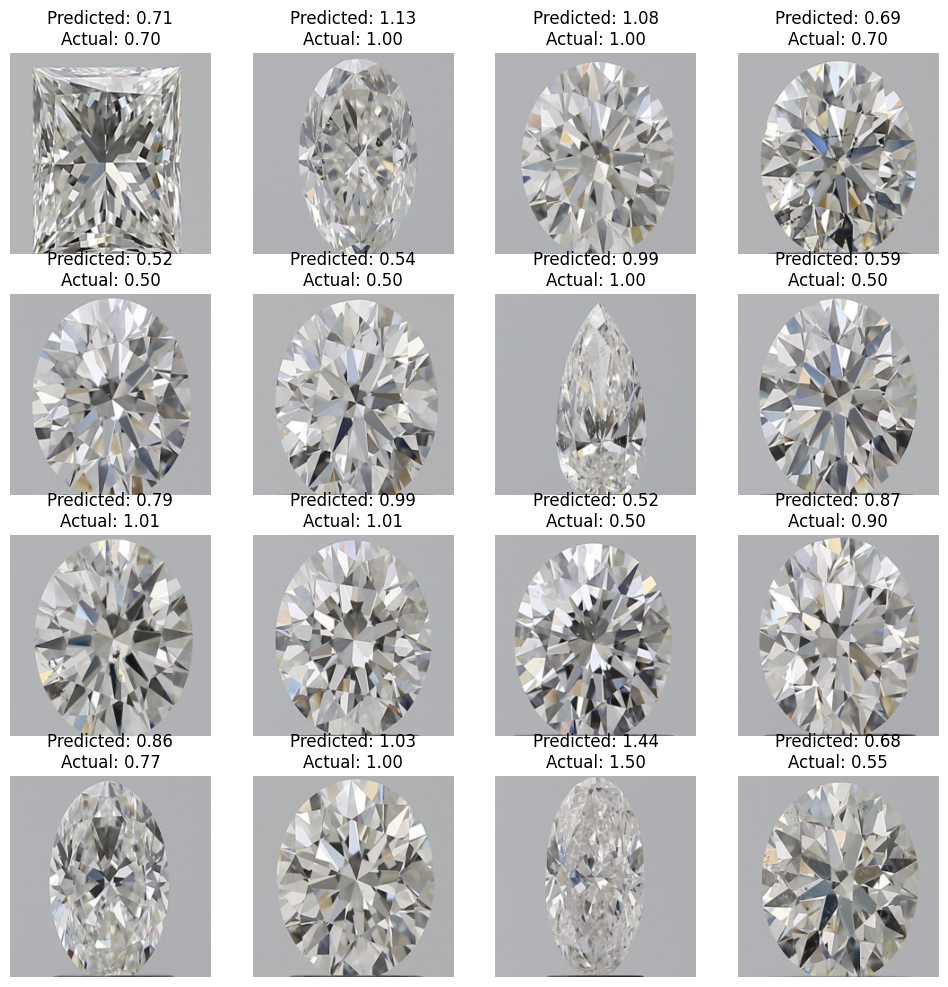

In [ ]:
sample = next(iter(test_loader))
images, labels = sample
images = images.to(device)
net.eval()
std = torch.tensor(std)
mean = torch.tensor(mean)

y_hat = net(images)
y_hat = y_hat.detach().cpu().numpy()

y_hat = scaler.inverse_transform(y_hat)
y_true = scaler.inverse_transform(labels.numpy().reshape(-1, 1))

images = images[:16].cpu()
y_hat = y_hat[:16]
y_true = y_true[:16]

fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    image = images[i].permute(1, 2, 0)
    image = (image * std) + mean
    ax.imshow(image)
    ax.set_title(f"Predicted: {y_hat[i][0]:.2f}\nActual: {y_true[i][0]:.2f}")
    ax.axis('off')

We compute the Root Mean Squared Error (RMSE) on the test set. Each batch of data is passed through the model, the difference between the predictions and the actual values is computed, and the errors are summed. In the end, we obtain the RMSE, which provides a precise indication of the model's performance on the test data.

In [ ]:
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.Linear(1024, 1))
model_path = resources + "/best_regression_model.pth"
net.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))


net.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

total_squared_error = 0.0
total_samples = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        outputs = outputs.view(-1)
        labels = labels.view(-1)

        squared_errors = (outputs - labels) ** 2

        total_squared_error += squared_errors.sum().item()
        total_samples += labels.size(0)

rmse = (total_squared_error / total_samples) ** 0.5
print(f'RMSE on test set: {rmse}')

RMSE on test set: 0.0804751918890006


##**Conclusion**

The goal of this project was to develop a model capable of predicting diamond carat values from images using a deep neural network. We worked with the "diamond images dataset," which contains 48,765 images of diamonds. To reduce the noise caused by the scarcity of data for diamonds with carats greater than 2.2, we decided to focus on diamonds with carats ≤ 2.2.

We applied several pre-processing techniques to improve the model's performance. The images were resized to 224x224 pixels and normalized using the mean and standard deviation of a sample of images. Additionally, the carat values were scaled using a MinMaxScaler to optimize the model’s continuous prediction.

The final result, with an RMSE of 0.08 on the test set, indicates a good model, despite the challenges posed by the initial dataset. The graphical results show that the model performed well in predicting carat values for diamonds up to 2.2 carats.